# TO DO
* feature engineering
* cost threshold chaning

# Information tab

* For more info on SMOTE see [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, roc_auc_score, plot_roc_curve, plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#import lightgbm as xgb

from features import update_dataset_features, text_to_binary, add_extra_features, encode_claim_cause

pd.set_option("display.max_columns",500)
plt.style.use('ggplot')

In [2]:
data_path = r"./train.csv"

In [3]:
df = pd.read_csv(data_path, sep=";", encoding="utf-8-sig")

In [ ]:
#df["claim_date_occured"] = pd.to_datetime(df["claim_date_occured"], format="%Y%m%d")
#min(df["claim_date_occured"].dt.year - df["policy_holder_year_birth"])

# Exploratory Data Analysis (EDA)

In [ ]:
pd.crosstab(df["fraud"], df["claim_vehicle_brand"], normalize=True)

In [ ]:
for i in df.columns:
    print(i)
    try:
        df[i].plot(kind="hist")
        plt.show()
        print(df[i].describe())
    except TypeError:
        values = df[i].value_counts()
        if len(values) < 10:
            values.plot(kind="bar")
            plt.show()
            print(df[i].describe())
        else:
            print('*******too many values to plot*******************')
            print(df[i].describe())
    print('*************************************************************************')

# Data cleaning

In [4]:
# read data in cell below to speed up and skip this step
df, claim_cause_ohe = update_dataset_features(df)

In [5]:
df.isna().sum()

fraud                                 0
claim_amount                          0
claim_liable                          0
claim_num_injured                     0
claim_num_third_parties               0
claim_num_vehicles                    0
claim_police                          0
claim_language                       43
claim_vehicle_type                  154
policy_holder_form                    0
policy_holder_country                 0
policy_num_changes                    0
policy_num_claims                     0
policy_premium_100                 9162
policy_coverage_1000              28420
cc1                                   0
cc2                                   0
cc3                                   0
cc4                                   0
cc5                                   0
cc6                                   0
cc7                                   0
cc8                                   0
claim_vehicle_id_count                0
policy_holder_id_count                0


# Train test split + prep

In [6]:
# claim_amount is currently dropped since poor performance
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:].drop(columns=["claim_amount"]), df["fraud"], test_size=.2, random_state=96)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df.drop(columns=["fraud", "claim_amount"]),
                                                                    df["claim_amount"], test_size=.2, random_state=96)

In [7]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
train_lang_mode = X_train["claim_language"].mode()[0]
train_vtype_mode = X_train["claim_vehicle_type"].mode()[0]

# mean
train_premium_mean = X_train["policy_premium_100"].mean()
train_coverage_mean = X_train["policy_coverage_1000"].mean()
#train_policy_holder_mean_age = X_train["policy_holder_age"].mean()

for train_set in [X_train, X_train_reg]:
    train_set["claim_language"].fillna(train_lang_mode, inplace=True)
    train_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)
    train_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    train_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    # train_set["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [8]:
# impute remaining missing values with mode or mean from train set on test set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

for test_set in [X_test, X_test_reg]:
    # mode
    test_set["claim_language"].fillna(train_lang_mode, inplace=True)
    test_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

    # mean
    test_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    test_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    # X_test["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

# Predicting claim amount

## Linear regression model

In [15]:
lm = LinearRegression().fit(X_train_reg, y_train_reg)

In [16]:
print("Training set R squared: {}".format(model.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(model.score(X_test_reg, y_test_reg)))

Training set R squared: 0.3977291568402235
Testing set R squared: 0.3664041278666226


In [17]:
print('intercept:', model.intercept_)
print('coef:', model.coef_)

intercept: 1233.050411645643
coef: [-4.20978235e+02  3.23688011e+03  8.61409343e+01  2.20732604e+02
  1.36872697e+02  7.53666295e+01  1.57768720e+01  4.17991637e+01
  3.22510683e+02  4.95042141e+01  3.93931914e+00  4.70104920e+01
  1.89896459e+01 -1.37887808e+03  6.62729848e+03 -1.39948512e+03
  2.00131340e+03 -1.62607780e+03 -1.65083739e+03 -8.80709600e+02
 -1.69262388e+03 -5.03298848e+02  1.26727865e+00  2.01097986e-01
  4.96366183e+02  5.54177082e-01  2.01173120e+00  3.28241702e+01
  2.27489804e+02  1.23712109e+02 -9.45533211e+01 -1.23686599e+02
  5.45422853e+02 -2.43952723e+01 -3.00697338e+01 -1.50795533e+02
  1.95241187e+02]


## Random Forest Regressor

In [156]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=2, max_features="sqrt", 
                           random_state=96, warm_start=True, bootstrap=True)
model2 = rf.fit(X_train_reg, y_train_reg)

In [157]:
print("Training set R squared: {}".format(model2.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(model2.score(X_test_reg, y_test_reg)))

Training set R squared: 0.37660510318621376
Testing set R squared: 0.36720509687806446


# Base Logistic Regression model - off the shelf

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [10]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [153]:
# we need to predict claim_amount on the testset to evaluate true performance
#X_test.drop(columns=["claim_amount"], inplace=True)
#X_test["claim_amount"] = model2.predict(X_test)

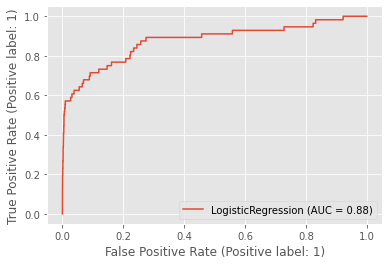

In [11]:
X_test_scaled = scaler.transform(X_test)
plot_roc_curve(clf, X_test_scaled, y_test)

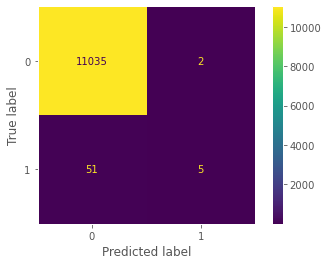

In [12]:
plot_confusion_matrix(clf, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Logistic Regression model - SMOTE

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [ ]:
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
# transform the dataset
X_train_scaled_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

In [ ]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

In [ ]:
clf_resampled = LogisticRegression(max_iter=500)
clf_resampled.fit(X_train_scaled_resampled, y_train_resampled)

In [ ]:
X_test_scaled = scaler.transform(X_test)
plot_roc_curve(clf_resampled, X_test_scaled, y_test)

In [ ]:
plot_confusion_matrix(clf_resampled, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Random Forest - SMOTE

In [262]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [263]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [264]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 29410
Minority class (1): 8823
ratio: 30.0%


In [265]:
rf = RandomForestClassifier(n_estimators=10000, max_depth=5, warm_start=True, random_state=9, n_jobs=2)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, n_estimators=10000, n_jobs=2,
                       random_state=9, warm_start=True)

In [ ]:
rf.feature_importances_

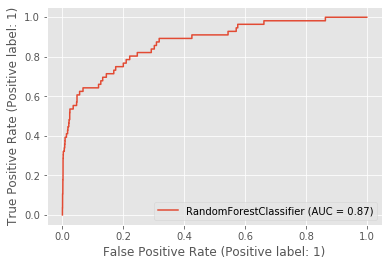

In [266]:
plot_roc_curve(rf, X_test, y_test)

In [ ]:
# check variable importance

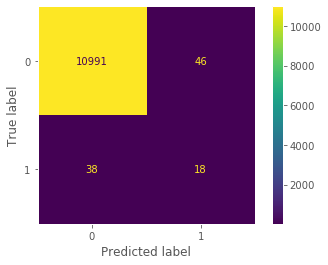

In [267]:
plot_confusion_matrix(rf, X_test, y_test)
plt.grid(False)
plt.show()

# Balanced random forest

See [here](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)

In [237]:
over = SMOTE(sampling_strategy=0.4)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

In [238]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [239]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 44118
Minority class (1): 17647
ratio: 40.0%


In [240]:
bclf = BalancedRandomForestClassifier(n_estimators=10000, max_depth=5, random_state=9, 
                                      n_jobs=2, class_weight="balanced_subsample")

In [241]:
bclf.fit(X_train_resampled, y_train_resampled)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                               n_estimators=10000, n_jobs=2, random_state=9)

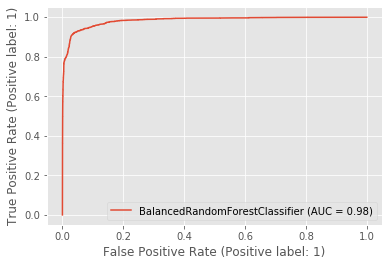

In [242]:
plot_roc_curve(bclf, X_train_resampled, y_train_resampled)

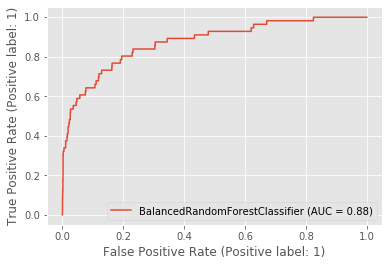

In [243]:
plot_roc_curve(bclf, X_test, y_test)

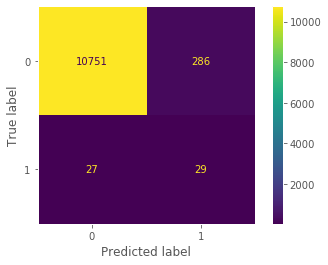

In [244]:
plot_confusion_matrix(bclf, X_test, y_test)
plt.grid(False)
plt.show()

# XGB

see [here](https://xgboost.readthedocs.io/en/latest/parameter.html) for information on all parameters

In [14]:
import xgboost as xgb

In [20]:
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
ratio = neg_length/pos_length

In [55]:
xgb_clf = xgb.XGBClassifier(n_estimators = 500, objective="binary:logistic", base_score=.99, eval_metric="logloss", seed=9, 
                            scale_pos_weight=1)

In [178]:
xgb_clf = xgb.XGBClassifier(n_estimators = 100, objective="binary:logistic", eval_metric="auc", seed=9, 
                            scale_pos_weight=ratio/5, reg_alpha=0.3, reg_lambda=5)

In [36]:
X_train.iloc[:,-9:] = X_train.iloc[:,-9:].astype(float)

In [179]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='auc', reg_alpha=0.3, reg_lambda=5,
              scale_pos_weight=35.01428571428572, seed=9)

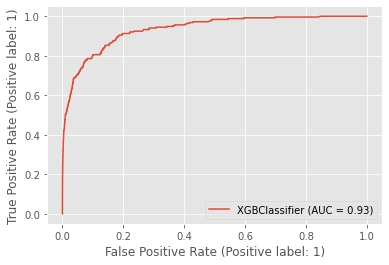

In [180]:
plot_roc_curve(xgb_clf, X_train, y_train)

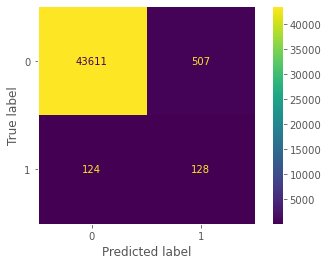

In [181]:
plot_confusion_matrix(xgb_clf, X_train, y_train)
plt.grid(False)
plt.show()

In [40]:
X_test.iloc[:,-9:] = X_test.iloc[:,-9:].astype(float)

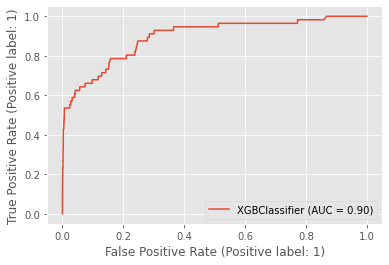

In [182]:
plot_roc_curve(xgb_clf, X_test, y_test)

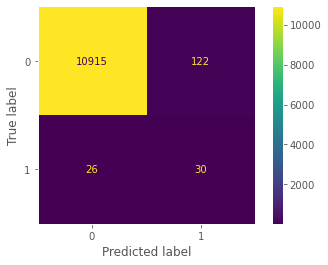

In [183]:
plot_confusion_matrix(xgb_clf, X_test, y_test)
plt.grid(False)
plt.show()

# Submission

In [60]:
submit_path = r"./test.csv"

In [61]:
submit_set = pd.read_csv(submit_path, sep=";", encoding="utf-8-sig")

In [62]:
df = submit_set
# convert binary text variables into binary: {"Y":1, "N":0}
for i in ["claim_liable", "claim_police", "driver_injured"]:
    text_to_binary(i, "Y", "N", df)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", df)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", df)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", df)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", df)
# make claim_lang binary (currently 1:Dutch, 2:Fr) -> 0: Dutch and 1: French
df["claim_language"] = df["claim_language"] - 1 

# get dummies for cat vars
df = encode_claim_cause(claim_cause_ohe, df)
#df = encode_ph_postal_code(phpc_ohe, df)

# format date
YYYYMMDD_date_columns = ["claim_date_registered",
                         "claim_date_occured"]
for i in YYYYMMDD_date_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m%d")

# remove extreme value
df["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value= np.nan, inplace=True)

YYYYMM_columns = ["claim_vehicle_date_inuse", 
                  "policy_date_start",
                  "policy_date_next_expiry",
                  "policy_date_last_renewed"]
for i in YYYYMM_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m")

In [63]:
# Add the extra features just like we did for the training set
df = add_extra_features(df)

In [64]:
# Hide the claim_id column as index so that it's not used as covariate for the prediction, but we can recover
# it later as we need claim_id in the output .csv file
df = df.set_index('claim_id')
#df = df[X_train.drop(columns=["claim_amount"]).columns]
df = df[X_train.columns]


In [125]:
df.isna().sum()

claim_liable                      0
claim_num_injured                 0
claim_num_third_parties           0
claim_num_vehicles                0
claim_police                      0
claim_language                    0
claim_vehicle_type                0
policy_holder_form                0
policy_holder_country             0
policy_num_changes                0
policy_num_claims                 0
policy_premium_100                0
policy_coverage_1000              0
cc1                               0
cc2                               0
cc3                               0
cc4                               0
cc5                               0
cc6                               0
cc7                               0
cc8                               0
claim_vehicle_id_count            0
policy_holder_id_count            0
driver_id_count                   0
driver_vehicle_id_count           0
third_party_1_id_count            0
third_party_1_vehicle_id_count    0
blacklisted_expert_id       

In [66]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
df["claim_language"].fillna(train_lang_mode, inplace=True)
df["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
df["policy_premium_100"].fillna(train_premium_mean, inplace=True)
df["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
# df["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [67]:
assert df.isna().sum().sum() == 0

In [107]:
# While we don't have a model yet to predict claim_amount, set it to 0.0
# TODO: Replace this with the predicted response variable of the regression model on the submission set.
#df['claim_amount'] = model2.predict(df)

In [136]:
submit_scaled = scaler.transform(df)

In [184]:
submit_not_scaled = df.copy()

In [185]:
# final submission set initialization
submission = df.reset_index()[['claim_id']]

In [138]:
# for logistic regression
submission["prediction"] = clf.predict_proba(submit_scaled)[:,1]

In [ ]:
# for logistic regression with SMOTE
submission["prediction"] = clf_resampled.predict_proba(submit_scaled)[:,1]

In [ ]:
# for rf with SMOTE
submission["prediction"] = rf.predict_proba(submit_not_scaled)[:,1]

In [255]:
# for balanced random forest
submission["prediction"] = bclf.predict_proba(submit_not_scaled)[:,1]

In [186]:
# for xgb
submit_not_scaled.iloc[:,-9:] = submit_not_scaled.iloc[:,-9:].astype(float)
submission["prediction"] = xgb_clf.predict_proba(submit_not_scaled)[:,1]

In [187]:
submission.columns

Index(['claim_id', 'prediction'], dtype='object')

In [188]:
submission.columns = ["ID", "PROB"]

In [189]:
submission.to_csv("submission_V0.19.csv", sep=',', index=False)